In [1]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

In [2]:
# Specify visible cuda device
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [3]:
import matplotlib.pyplot as plt

from param import *
from lib.model import *
from lib.utils import *

Using TensorFlow backend.


In [4]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

Load MNIST dataset

In [5]:
# Load MNIST
x_train, y_train, x_test, y_test = load_mnist()

Load ACGAN

In [6]:
g = acgan_mnist_model_g_old()
g.load_weights(WEIGHT_DIR + "./acgan_mnist/weight_g_epoch_012.hdf5")

d = acgan_mnist_model_d()
d.load_weights(WEIGHT_DIR + "./acgan_mnist/weight_d_epoch_012.hdf5")

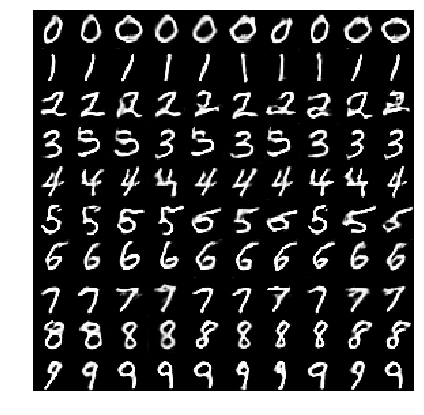

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   [0.39, 0.5, 0.42, 0.33, 0.4, 0.46, 0.44, 0.42, 0.55, 0.51]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]   [0.3, 0.51, 0.6, 0.29, 0.5, 0.31, 0.25, 0.22, 0.55, 0.46]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]   [0.53, 0.76, 0.48, 0.7, 0.43, 0.73, 0.51, 0.7, 0.67, 0.35]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]   [0.28, 0.67, 0.71, 0.29, 0.53, 0.3, 0.61, 0.35, 0.34, 0.27]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]   [0.63, 0.58, 0.61, 0.39, 0.59, 0.44, 0.42, 0.53, 0.36, 0.45]
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5]   [0.46, 0.24, 0.37, 0.25, 0.4, 0.42, 0.53, 0.25, 0.81, 0.32]
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6]   [0.24, 0.34, 0.56, 0.41, 0.45, 0.45, 0.57, 0.5, 0.29, 0.32]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7]   [0.47, 0.44, 0.82, 0.43, 0.62, 0.58, 0.18, 0.44, 0.79, 0.68]
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8]   [0.47, 0.45, 0.3, 0.19, 0.42, 0.35, 0.45, 0.32, 0.43, 0.55]
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9]   [0.43, 0.4, 0.28, 0.34, 0.32, 0.3, 0.34, 0.36, 0.31, 0.31]


In [7]:
def collage(images):
    img = (np.concatenate([np.concatenate([s for s in r], axis=1)
                           for r in np.split(images, 10)], axis=0) *
           127.5 + 127.5).astype(np.uint8)
    return np.squeeze(img)

noise = np.random.uniform(-1, 1, (100, LATENT_SIZE))
sampled_labels = np.array([[i] * 10 for i in range(10)]).reshape(-1, 1)
#sampled_target = np.array([[i for i in range(10)] * 10]).reshape(-1, 1)

# get a batch to display
x_g = g.predict([noise, sampled_labels], verbose=0)

img = collage(x_g)
plt.figure(figsize=(7,7))
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.savefig('acgan_vis.png', bbox_inches='tight')
plt.show()

y_pred = []
fake = []

for i, x in enumerate(x_g):
    tmp = d.predict(x.reshape(1, 28, 28, 1))
    fake.append(round(float(tmp[0]), 2))
    y_pred.append(np.argmax(tmp[1]))
    if (i + 1) % 10 == 0:
        print("{}   {}".format(y_pred, fake))
        y_pred = []
        fake = []

Load MNIST CNN classifier

In [8]:
cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28, 28, 1)))
cnn.add(Conv2D(64, (3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(10, activation='softmax'))

cnn.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
cnn.load_weights('test_cnn_mnist.h5')
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0907250769441
Test accuracy: 0.9754


Analysis on ACGAN

In [9]:
def random_sample(size):
    # Generate samples from g
    z = np.random.uniform(-1, 1, (size, LATENT_SIZE))
    # Sampled labels
    y_sampled = np.random.randint(0, 10, size)
    return z, y_sampled

def generate_random(g, size):
    z, y_sampled = random_sample(size)
    x_g = g.predict([z, y_sampled.reshape((-1, 1))], verbose=0)
    return x_g, y_sampled

def generate_label(g, label, size):
    z = np.random.uniform(-1, 1, (size, LATENT_SIZE))
    y = np.zeros(size) + label
    return g.predict([z, y.reshape((-1, 1))], verbose=0)

def collage(images):
    img = (np.concatenate([np.concatenate([s for s in r], axis=1)
                           for r in np.split(images, 10)], axis=0) *
           SCALE + SCALE).astype(np.uint8)
    return np.squeeze(img)

def show(x):
    plt.imshow(x.reshape(28, 28) / 2 + 1, cmap='gray')
    plt.axis('off')
    plt.show()

In [10]:
r_r = 1
r_g = 0.01
dropout = True

In [11]:
n_train, n_test = len(x_train), len(x_test)

ind = np.random.choice(n_train, int(n_train * r_r))
x_r, y_r = x_train[ind], y_train[ind]
x_g, y_g = generate_random(g, int(n_train * r_g))
if r_g == 0:
    x_rg, y_rg = x_r, y_r
elif r_r == 0:
    x_rg, y_rg = x_g, y_g
else:
    x_rg = np.concatenate((x_r, x_g), axis=0)
    y_rg = np.concatenate((y_r, y_g), axis=0)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
if dropout:
    model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
if dropout:
    model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
weight = 'mnist_cnn_r{}_g{}.hdf5'.format(r_r, r_g)
saveBestModel = ModelCheckpoint(weight, monitor='val_loss', verbose=1, 
                                save_best_only=True, mode='auto')

model.fit(x_rg, y_rg,
          batch_size=128,
          epochs=50,
          verbose=1,
          callbacks=[earlyStopping, saveBestModel],
          validation_data=(x_test, y_test))
score_test = model.evaluate(x_test, y_test, verbose=0)
score_train = model.evaluate(x_train, y_train, verbose=0)
score = [score_test[0], score_test[1], score_train[0], score_train[1]]
print(score)

Train on 60600 samples, validate on 10000 samples
Epoch 1/50
60600/60600 [==============================] - 5s 82us/step - loss: 0.3292 - acc: 0.8982 - val_loss: 0.0694 - val_acc: 0.9784
Epoch 2/50
60600/60600 [==============================] - 5s 79us/step - loss: 0.1040 - acc: 0.9692 - val_loss: 0.0514 - val_acc: 0.9820
Epoch 3/50
60600/60600 [==============================] - 5s 78us/step - loss: 0.0764 - acc: 0.9773 - val_loss: 0.0403 - val_acc: 0.9865
Epoch 4/50
60600/60600 [==============================] - 5s 78us/step - loss: 0.0605 - acc: 0.9820 - val_loss: 0.0394 - val_acc: 0.9866
Epoch 5/50
60600/60600 [==============================] - 5s 79us/step - loss: 0.0517 - acc: 0.9841 - val_loss: 0.0361 - val_acc: 0.9877
Epoch 6/50
60600/60600 [==============================] - 5s 79us/step - loss: 0.0452 - acc: 0.9867 - val_loss: 0.0355 - val_acc: 0.9881
Epoch 7/50
60600/60600 [==============================] - 5s 78us/step - loss: 0.0402 - acc: 0.9875 - val_loss: 0.0362 - val_acc

### Unbalanced data

In [12]:
rmv_cls = 0
keep_ratio = 0
replace = True
dropout = True

In [13]:
# Find indices of the class to remove
ind = np.where(y_train == rmv_cls)[0]
# Pick randomly
n_rmv = int(len(ind) * (1 - keep_ratio))
np.random.shuffle(ind)
del_ind = ind[:n_rmv]

if replace:
    # Replace the chosen indices with generated samples
    x_rg = np.copy(x_train)
    x_g = generate_label(g, rmv_cls, n_rmv)
    x_rg[del_ind] = x_g
    y_rg = y_train
else:
    x_rg = np.delete(x_train, del_ind, axis=0)
    y_rg = np.delete(y_train, del_ind, axis=0)
    
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
if dropout:
    model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
if dropout:
    model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
weight = 'mnist_cnn_rmvcls{}_rmvr{}.hdf5'.format(rmv_cls, keep_ratio)
saveBestModel = ModelCheckpoint(weight, monitor='val_loss', verbose=1, 
                                save_best_only=True, mode='auto')

model.fit(x_rg, y_rg,
          batch_size=128,
          epochs=50,
          verbose=1,
          callbacks=[earlyStopping, saveBestModel],
          validation_data=(x_test, y_test))
score_test = model.evaluate(x_test, y_test, verbose=0)
score_train = model.evaluate(x_train, y_train, verbose=0)
score = [score_test[0], score_test[1], score_train[0], score_train[1]]
print(score)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 79us/step - loss: 0.2939 - acc: 0.9104 - val_loss: 0.1264 - val_acc: 0.9613
Epoch 2/50
60000/60000 [==============================] - 5s 79us/step - loss: 0.0945 - acc: 0.9722 - val_loss: 0.1318 - val_acc: 0.9616
Epoch 3/50
60000/60000 [==============================] - 5s 78us/step - loss: 0.0732 - acc: 0.9780 - val_loss: 0.1107 - val_acc: 0.9674
Epoch 4/50
60000/60000 [==============================] - 5s 78us/step - loss: 0.0601 - acc: 0.9826 - val_loss: 0.1320 - val_acc: 0.9658
Epoch 5/50
60000/60000 [==============================] - 5s 78us/step - loss: 0.0527 - acc: 0.9847 - val_loss: 0.1456 - val_acc: 0.9643
Epoch 6/50
60000/60000 [==============================] - 4s 74us/step - loss: 0.0492 - acc: 0.9850 - val_loss: 0.1598 - val_acc: 0.9621
Epoch 7/50
60000/60000 [==============================] - 5s 78us/step - loss: 0.0436 - acc: 0.9867 - val_loss: 0.1441 - val_acc

In [14]:
ind = np.where(y_test == rmv_cls)[0]
model.evaluate(x_test[ind], y_test[ind], verbose=0)

[1.517620780516644, 0.68469387767266254]

In [5]:
from collections import defaultdict
import pickle as pickle
from PIL import Image
from six.moves import range
import keras.backend as K
import tensorflow as tf
from keras.datasets import cifar10
from keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from keras.utils.generic_utils import Progbar
from Minibatch import MinibatchDiscrimination
import matplotlib.pyplot as plt
from keras.layers.noise import GaussianNoise

In [6]:
def build_generator(latent_size):
    # we will map a pair of (z, L), where z is a latent vector and L is a
    # label drawn from P_c, to image space (..., 3, 32, 32)
    cnn = Sequential()
    cnn.add(Dense(384 * 4 * 4, input_dim=latent_size, activation='relu',
                  kernel_initializer='TruncatedNormal', bias_initializer='Zeros'))
    cnn.add(Reshape((384, 4, 4)))

    cnn.add(Conv2DTranspose(192, kernel_size=5, strides=2, padding='same', activation='relu',
                            kernel_initializer='TruncatedNormal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())

    cnn.add(Conv2DTranspose(96, kernel_size=5, strides=2, padding='same', activation='relu',
                            kernel_initializer='TruncatedNormal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())

    cnn.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh',
                            kernel_initializer='TruncatedNormal', bias_initializer='Zeros'))

    # this is the z space commonly refered to in GAN papers
    latent = Input(shape=(latent_size, ))

    # this will be our label
    image_class = Input(shape=(1,), dtype='int32')

    # 10 classes in CIFAR-10
    cls = Flatten()(Embedding(10, latent_size,
                              embeddings_initializer='TruncatedNormal')(image_class))

    # hadamard product between z-space and a class conditional embedding
    h = layers.multiply([latent, cls])

    fake_image = cnn(h)

    return Model([latent, image_class], fake_image)


def build_discriminator():
    # build a relatively standard conv net, with LeakyReLUs as suggested in
    # the reference paper
    cnn = Sequential()

    cnn.add(GaussianNoise(0.05, input_shape=(3, 32, 32))) #Add this layer to prevent D from overfitting!

    cnn.add(Conv2D(16, kernel_size=3, strides=2, padding='same',
                   kernel_initializer='TruncatedNormal', bias_initializer='Zeros'))
    cnn.add(LeakyReLU(alpha=0.2))
    cnn.add(Dropout(0.5))

    cnn.add(Conv2D(32, kernel_size=3, strides=1, padding='same',
                   kernel_initializer='TruncatedNormal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())
    cnn.add(LeakyReLU(alpha=0.2))
    cnn.add(Dropout(0.5))

    cnn.add(Conv2D(64, kernel_size=3, strides=2, padding='same',
                   kernel_initializer='TruncatedNormal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())
    cnn.add(LeakyReLU(alpha=0.2))
    cnn.add(Dropout(0.5))

    cnn.add(Conv2D(128, kernel_size=3, strides=1, padding='same',
                   kernel_initializer='TruncatedNormal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())
    cnn.add(LeakyReLU(alpha=0.2))
    cnn.add(Dropout(0.5))

    cnn.add(Conv2D(256, kernel_size=3, strides=2, padding='same',
                   kernel_initializer='TruncatedNormal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())
    cnn.add(LeakyReLU(alpha=0.2))
    cnn.add(Dropout(0.5))

    cnn.add(Conv2D(512, kernel_size=3, strides=1, padding='same',
                   kernel_initializer='TruncatedNormal', bias_initializer='Zeros'))
    cnn.add(BatchNormalization())
    cnn.add(LeakyReLU(alpha=0.2))
    cnn.add(Dropout(0.5))

    cnn.add(Flatten())

    cnn.add(MinibatchDiscrimination(50, 30))

    image = Input(shape=(3, 32, 32))

    features = cnn(image)

    # first output (name=generation) is whether or not the discriminator
    # thinks the image that is being shown is fake, and the second output
    # (name=auxiliary) is the class that the discriminator thinks the image
    # belongs to.
    fake = Dense(1, activation='sigmoid', name='generation',
                 kernel_initializer='TruncatedNormal', bias_initializer='Zeros')(features)
    aux = Dense(10, activation='softmax', name='auxiliary',
                kernel_initializer='TruncatedNormal', bias_initializer='Zeros')(features)

    return Model(image, [fake, aux])

In [15]:
def random_sample(size):

    # Generate samples from g
    z = np.random.normal(0, 0.5, (size, 110))
    # Sampled labels
    y_sampled = np.random.randint(0, 10, size)
    return z, y_sampled

def generate_random(g, size):

    z, y_sampled = random_sample(size)
    x_g = g.predict([z, y_sampled.reshape((-1, 1))], verbose=0)
    return x_g, y_sampled

def generate_label(g, label, size):
    z = np.random.uniform(-1, 1, (size, LATENT_SIZE))
    y = np.zeros(size) + label
    return g.predict([z, y.reshape((-1, 1))], verbose=0)

In [8]:
K.set_image_dim_ordering('th')

latent_size = 110

# build the discriminator and generator
d = build_discriminator()
g = build_generator(latent_size)

d.load_weights("./Keras-ACGAN-CIFAR10/params_discriminator_epoch_063.hdf5")
g.load_weights("./Keras-ACGAN-CIFAR10/params_generator_epoch_063.hdf5")

In [9]:
x_train, y_train, x_test, y_test = load_cifar10()
x_train, x_test = x_train.squeeze(), x_test.squeeze()
y_train, y_test = y_train.squeeze(), y_test.squeeze()

In [26]:
r_r = 0.002
r_g = 2

In [27]:
n_train, n_test = len(x_train), len(x_test)

ind = np.random.choice(n_train, int(n_train * r_r))
x_r, y_r = x_train[ind], y_train[ind]
x_g, y_g = generate_random(g, int(n_train * r_g))
if r_g == 0:
    x_rg, y_rg = x_r, y_r
elif r_r == 0:
    x_rg, y_rg = x_g, y_g
else:
    x_rg = np.concatenate((x_r, x_g), axis=0)
    y_rg = np.concatenate((y_r, y_g), axis=0)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
weight = 'cifar10_cnn_r{}_g{}.hdf5'.format(r_r, r_g)
saveBestModel = ModelCheckpoint(weight, monitor='val_loss', verbose=1, 
                                save_best_only=True, mode='auto')

model.fit(x_rg, y_rg,
          batch_size=32,
          epochs=100,
          callbacks=[earlyStopping, saveBestModel],
          validation_data=(x_test, y_test),
          shuffle=True)

# datagen = ImageDataGenerator(
#             featurewise_center=False,  # set input mean to 0 over the dataset
#             samplewise_center=False,  # set each sample mean to 0
#             featurewise_std_normalization=False,  # divide inputs by std of the dataset
#             samplewise_std_normalization=False,  # divide each input by its std
#             zca_whitening=False,  # apply ZCA whitening
#             rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
#             width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#             height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#             horizontal_flip=True,  # randomly flip images
#             vertical_flip=False)  # randomly flip images

# # Compute quantities required for feature-wise normalization
# # (std, mean, and principal components if ZCA whitening is applied).
# datagen.fit(x_train)

# # Fit the model on the batches generated by datagen.flow().
# model.fit_generator(datagen.flow(x_train, y_train,
#                                  batch_size=32),
#                     steps_per_epoch=1562,
#                     epochs=100,
#                     callbacks=[earlyStopping, saveBestModel],
#                     validation_data=(x_test, y_test),
#                     workers=4)

score_test = model.evaluate(x_test, y_test, verbose=0)
score_train = model.evaluate(x_train, y_train, verbose=0)
score = [score_test[0], score_test[1], score_train[0], score_train[1]]
print(score)

Train on 100100 samples, validate on 10000 samples
Epoch 1/100
100100/100100 [==============================] - 49s 489us/step - loss: 0.8075 - acc: 0.7248 - val_loss: 2.2566 - val_acc: 0.4184
Epoch 2/100
100100/100100 [==============================] - 48s 475us/step - loss: 0.2075 - acc: 0.9312 - val_loss: 2.5594 - val_acc: 0.4460
Epoch 3/100
100100/100100 [==============================] - 47s 474us/step - loss: 0.1128 - acc: 0.9627 - val_loss: 2.6547 - val_acc: 0.4589
Epoch 4/100
100100/100100 [==============================] - 48s 476us/step - loss: 0.0778 - acc: 0.9746 - val_loss: 2.7934 - val_acc: 0.4632
Epoch 5/100
100100/100100 [==============================] - 47s 473us/step - loss: 0.0620 - acc: 0.9798 - val_loss: 3.0770 - val_acc: 0.4652
Epoch 6/100
100100/100100 [==============================] - 48s 475us/step - loss: 0.0511 - acc: 0.9835 - val_loss: 2.5721 - val_acc: 0.4672
Epoch 00006: early stopping
[2.5720944866180422, 0.4672, 2.5579320460510253, 0.47255999999999998]

In [14]:
from keras.preprocessing.image import ImageDataGenerator

In [35]:
rmv_cls = 0
keep_ratio = 0
replace = True
dropout = True

In [36]:
# Find indices of the class to remove
ind = np.where(y_train == rmv_cls)[0]
# Pick randomly
n_rmv = int(len(ind) * (1 - keep_ratio))
np.random.shuffle(ind)
del_ind = ind[:n_rmv]

if replace:
    # Replace the chosen indices with generated samples
    x_rg = np.copy(x_train)
    x_g = generate_label(g, rmv_cls, n_rmv)
    x_rg[del_ind] = x_g
    y_rg = y_train
else:
    x_rg = np.delete(x_train, del_ind, axis=0)
    y_rg = np.delete(y_train, del_ind, axis=0)
    
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
weight = 'cifar10_cnn_rmvcls{}_rmvr{}.hdf5'.format(rmv_cls, keep_ratio)
saveBestModel = ModelCheckpoint(weight, monitor='val_loss', verbose=1, 
                                save_best_only=True, mode='auto')

model.fit(x_rg, y_rg,
          batch_size=32,
          epochs=100,
          callbacks=[earlyStopping, saveBestModel],
          validation_data=(x_test, y_test),
          shuffle=True)

score_test = model.evaluate(x_test, y_test, verbose=0)
score_train = model.evaluate(x_train, y_train, verbose=0)
score = [score_test[0], score_test[1], score_train[0], score_train[1]]
print(score)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 25s 494us/step - loss: 1.6938 - acc: 0.3773 - val_loss: 1.4967 - val_acc: 0.4607
Epoch 2/100
50000/50000 [==============================] - 24s 482us/step - loss: 1.3448 - acc: 0.5124 - val_loss: 1.3552 - val_acc: 0.5167
Epoch 3/100
50000/50000 [==============================] - 24s 481us/step - loss: 1.1985 - acc: 0.5694 - val_loss: 1.2877 - val_acc: 0.5593
Epoch 4/100
50000/50000 [==============================] - 24s 482us/step - loss: 1.0906 - acc: 0.6129 - val_loss: 1.2194 - val_acc: 0.5881
Epoch 5/100
50000/50000 [==============================] - 24s 479us/step - loss: 1.0071 - acc: 0.6404 - val_loss: 1.3445 - val_acc: 0.5923
Epoch 6/100
50000/50000 [==============================] - 24s 481us/step - loss: 0.9420 - acc: 0.6660 - val_loss: 1.2985 - val_acc: 0.6104
Epoch 7/100
50000/50000 [==============================] - 24s 482us/step - loss: 0.8844 - acc: 0.6858 - val_l

In [37]:
ind = np.where(y_test == rmv_cls)[0]
model.evaluate(x_test[ind], y_test[ind], verbose=0)

[6.0985440711975096, 0.112]

### No Dropout

Experiments without dropout layers

In [62]:
r_r = 1
r_g = 0.1

In [63]:
n_train, n_test = len(x_train), len(x_test)

ind = np.random.choice(n_train, int(n_train * r_r))
x_r, y_r = x_train[ind], y_train[ind]
x_g, y_g = generate_random(g, int(n_train * r_g))
if r_g == 0:
    x_rg, y_rg = x_r, y_r
elif r_r == 0:
    x_rg, y_rg = x_g, y_g
else:
    x_rg = np.concatenate((x_r, x_g), axis=0)
    y_rg = np.concatenate((y_r, y_g), axis=0)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
weight = 'cifar10_cnn_nodrop_r{}_g{}.hdf5'.format(r_r, r_g)
saveBestModel = ModelCheckpoint(weight, monitor='val_loss', verbose=1, 
                                save_best_only=True, mode='auto')

model.fit(x_rg, y_rg,
          batch_size=32,
          epochs=100,
          callbacks=[earlyStopping, saveBestModel],
          validation_data=(x_test, y_test),
          shuffle=True)

score_test = model.evaluate(x_test, y_test, verbose=0)
score_train = model.evaluate(x_train, y_train, verbose=0)
score = [score_test[0], score_test[1], score_train[0], score_train[1]]
print(score)

Train on 55000 samples, validate on 10000 samples
Epoch 1/100
55000/55000 [==============================] - 29s 529us/step - loss: 1.5834 - acc: 0.4306 - val_loss: 1.4049 - val_acc: 0.5016
Epoch 2/100
55000/55000 [==============================] - 27s 493us/step - loss: 1.2550 - acc: 0.5537 - val_loss: 1.2105 - val_acc: 0.5750
Epoch 3/100
55000/55000 [==============================] - 27s 495us/step - loss: 1.0937 - acc: 0.6180 - val_loss: 1.1337 - val_acc: 0.5973
Epoch 4/100
55000/55000 [==============================] - 27s 491us/step - loss: 0.9560 - acc: 0.6689 - val_loss: 1.0576 - val_acc: 0.6273
Epoch 5/100
55000/55000 [==============================] - 27s 492us/step - loss: 0.8419 - acc: 0.7125 - val_loss: 0.9714 - val_acc: 0.6621
Epoch 6/100
55000/55000 [==============================] - 27s 484us/step - loss: 0.7433 - acc: 0.7467 - val_loss: 0.9610 - val_acc: 0.6715
Epoch 7/100
55000/55000 [==============================] - 27s 490us/step - loss: 0.6594 - acc: 0.7777 - val_l

9


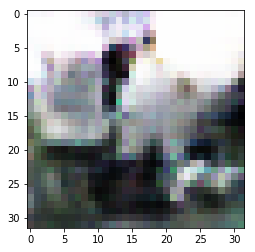

9


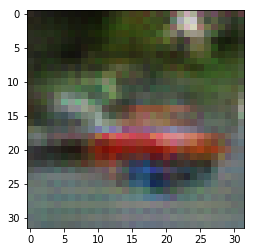

3


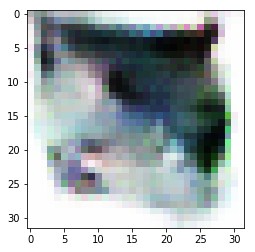

8


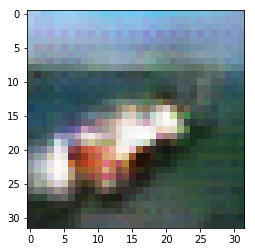

2


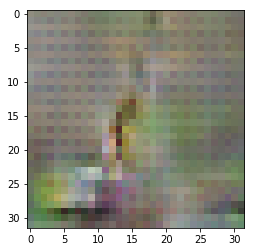

6


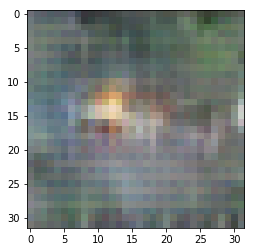

5


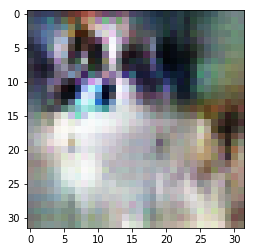

6


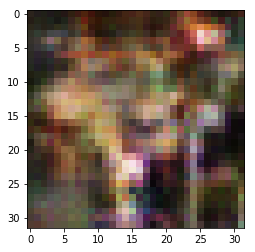

5


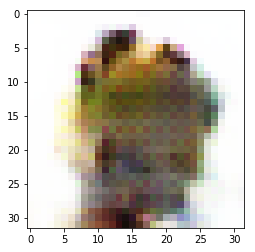

9


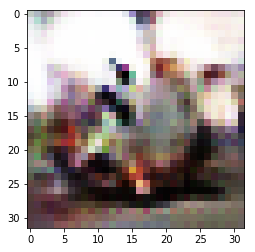

2


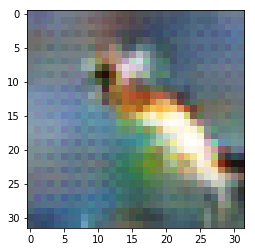

1


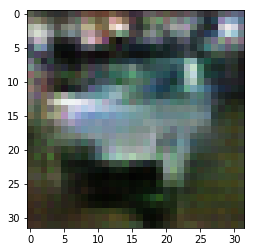

7


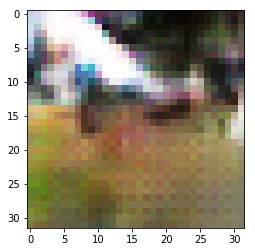

7


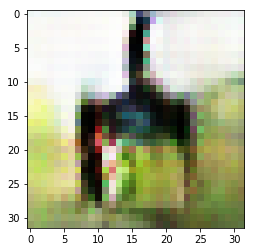

5


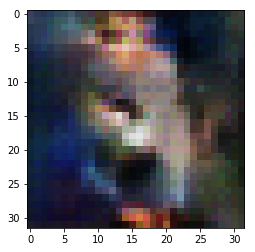

8


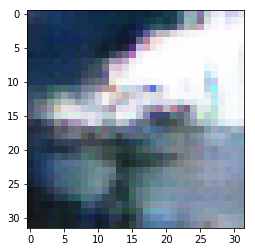

7


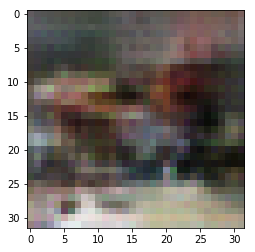

2


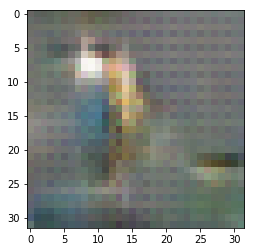

1


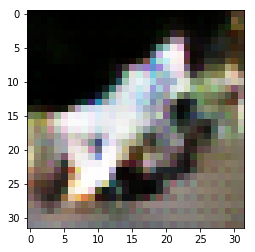

1


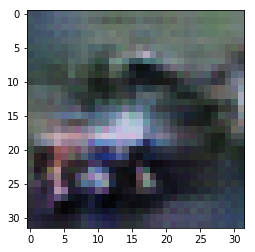

In [70]:
for i in range(20):
    print(y_g[i])
    plt.imshow(x_g[i].transpose(1,2,0) / 2 + 0.5)
    plt.show()

---
Train MNIST CNN classifier

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 3s - loss: 0.3242 - acc: 0.8997 - val_loss: 0.0721 - val_acc: 0.9785
Epoch 2/12
60000/60000 [==============================] - 3s - loss: 0.1067 - acc: 0.9678 - val_loss: 0.0484 - val_acc: 0.9833
Epoch 3/12
60000/60000 [==============================] - 3s - loss: 0.0791 - acc: 0.9761 - val_loss: 0.0422 - val_acc: 0.9854
Epoch 4/12
60000/60000 [==============================] - 3s - loss: 0.0668 - acc: 0.9807 - val_loss: 0.0361 - val_acc: 0.9873
Epoch 5/12
60000/60000 [==============================] - 3s - loss: 0.0571 - acc: 0.9831 - val_loss: 0.0331 - val_acc: 0.9885
Epoch 6/12
60000/60000 [==============================] - 3s - loss: 0.0528 - acc: 0.9841 - val_loss: 0.0335 - val_acc: 0.9893
Epoch 7/12
60000/60000 [==============================] - 3s - loss: 0.0464 - acc: 0.9862 - val_loss: 0.0312 - val_acc: 0.9900
Epoch 8/12
60000/60000 [==============================] - 3s 

OSError: Unable to create file (Unable to truncate a file which is already open)

In [ ]:
train(prog=True)

Epoch 1 of 50
467/468 [============================>.] - ETA: 0s
Testing for epoch 1:
component              | loss
-----------------------------------------------------------------
generator (train)      | 1.0436
generator (test)       | 0.6704
discriminator (train)  | 1.6959
discriminator (test)   | 2.2709
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 7, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Accuracy: 0.8705
Epoch 2 of 50
467/468 [============================>.] - ETA: 0s
Testing for epoch 2:
component              | loss
-----------------------------------------------------------------
generator (train)      | 0.7552
generator (test)       | 0.6748
discriminator (train)  | 1.7514
discriminator (test)   | 2.2990
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 

In [ ]:
from lib.model_acgan_cifar10 import *

def train(prog=True):
    """Main function to train GAN"""

    # Load MNIST
    x_train, y_train, x_test, y_test = load_cifar10()
    x_train, x_test = x_train.squeeze(), x_test.squeeze()
    y_train, y_test = y_train.squeeze(), y_test.squeeze()

    # Build model
    d = build_discriminator()
    g = build_generator()

    # Set up optimizers
    adam = Adam(lr=adam_lr, beta_1=adam_beta_1)

    # Set loss function and compile models
    g.compile(optimizer=adam, loss='binary_crossentropy')
    d.compile(
        optimizer=adam,
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy'])
    combined = combine_g_d(g, d)
    combined.compile(
        optimizer=adam,
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy'])

    train_history = defaultdict(list)
    test_history = defaultdict(list)

    n_train = x_train.shape[0]
    n_batch = int(n_train / BATCH_SIZE)
    for epoch in range(N_EPOCH):
        print('Epoch {} of {}'.format(epoch + 1, N_EPOCH))
        progress_bar = Progbar(target=n_batch)

        epoch_g_loss = []
        epoch_d_loss = []

        for index in range(n_batch):
            progress_bar.update(index, force=True)
            d_loss = np.zeros(3)

            # Train the discriminator for N_DIS iterations before training
            # the generator once
            for _ in range(N_DIS):
                # ----------------- Train discriminator ---------------------- #
                # Train with real samples first
                smp_ind = np.random.choice(n_train, BATCH_SIZE)
                x_real = x_train[smp_ind]
                y_real = y_train[smp_ind]
                if index % 30 != 0:
                    y_d = np.random.uniform(0.7, 1.2, size=(BATCH_SIZE, ))
                else:
                    y_d = np.random.uniform(0.0, 0.3, size=(BATCH_SIZE, ))
                d_loss += d.train_on_batch(x_real, [y_d, y_real])

                # Train with generated samples, generate samples from g
                z = np.random.normal(0, 0.5, (BATCH_SIZE, LATENT_SIZE))
                # Sample some labels from p_c
                y_sampled = np.random.randint(0, 10, BATCH_SIZE)
                x_g = g.predict([z, y_sampled.reshape((-1, 1))], verbose=0)
                if index % 30 != 0:
                    y_d = np.random.uniform(0.0, 0.3, size=(BATCH_SIZE, ))
                else:
                    y_d = np.random.uniform(0.7, 1.2, size=(BATCH_SIZE, ))
                d_loss += d.train_on_batch(x_g, [y_d, y_sampled])

            # Log average discriminator loss over N_DIS
            epoch_d_loss.append(d_loss / N_DIS)

            # ---------------- Train generator ------------------------------- #
            # Generate 2 * BATCH_SIZE samples to match d's batch size
            z = np.random.uniform(0, 0.5, (2 * BATCH_SIZE, LATENT_SIZE))
            y_sampled = np.random.randint(0, 10, 2 * BATCH_SIZE)
            y_g = np.random.uniform(0.7, 1.2, size=(2 * BATCH_SIZE, ))

            epoch_g_loss.append(combined.train_on_batch(
                [z, y_sampled.reshape((-1, 1))], [y_g, y_sampled]))

        print('\nTesting for epoch {}:'.format(epoch + 1))
        n_test = x_test.shape[0]

        # ---------------- Test discriminator -------------------------------- #
        z = np.random.uniform(0, 0.5, (n_test, LATENT_SIZE))
        y_sampled = np.random.randint(0, 10, n_test)
        x_g = g.predict([z, y_sampled.reshape((-1, 1))], verbose=0)

        x_d = np.concatenate((x_test, x_g))
        y_d = np.array([1] * n_test + [0] * n_test)
        y_aux = np.concatenate((y_test, y_sampled), axis=0)

        d_test_loss = d.evaluate(x_d, [y_d, y_aux], verbose=0)
        d_train_loss = np.mean(np.array(epoch_d_loss), axis=0)

        # ---------------- Test generator ------------------------------------ #
        z = np.random.uniform(0, 0.5, (2 * n_test, LATENT_SIZE))
        y_sampled = np.random.randint(0, 10, 2 * n_test)
        y_g = np.ones(2 * n_test)

        g_test_loss = combined.evaluate(
            [z, y_sampled.reshape((-1, 1))], [y_g, y_sampled], verbose=0)
        g_train_loss = np.mean(np.array(epoch_g_loss), axis=0)

        # generate an epoch report on performance
        train_history['generator'].append(g_train_loss)
        train_history['discriminator'].append(d_train_loss)
        test_history['generator'].append(g_test_loss)
        test_history['discriminator'].append(d_test_loss)

        print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format(
            'component', *d.metrics_names))
        print('-' * 65)

        ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.2f} | {3:<5.2f}'
        print(ROW_FMT.format('generator (train)',
                             *train_history['generator'][-1]))
        print(ROW_FMT.format('generator (test)',
                             *test_history['generator'][-1]))
        print(ROW_FMT.format('discriminator (train)',
                             *train_history['discriminator'][-1]))
        print(ROW_FMT.format('discriminator (test)',
                             *test_history['discriminator'][-1]))

        # Aave weights every epoch
        g.save_weights("{}weight_g_epoch_{:03d}.hdf5".format(
            WEIGHT_DIR, epoch), True)
        d.save_weights("{}weight_d_epoch_{:03d}.hdf5".format(
            WEIGHT_DIR, epoch), True)

        # generate some digits to display
        noise = np.random.uniform(0, 0.5, (100, LATENT_SIZE))

        sampled_labels = np.array([
            [i] * 10 for i in range(10)
        ]).reshape(-1, 1)

        # get a batch to display
        generated_images = g.predict(
            [noise, sampled_labels], verbose=0)

        def vis_square(data, padsize=1, padval=-1):

            # force the number of filters to be square
            n = int(np.ceil(np.sqrt(data.shape[0])))
            padding = ((0, n ** 2 - data.shape[0]), (0, padsize), 
                       (0, padsize)) + ((0, 0),) * (data.ndim - 3)
            data = np.pad(data, padding, mode='constant', 
                          constant_values=(padval, padval))

            # tile the filters into an image
            data = data.reshape((n, n) + data.shape[1:]).transpose(
                (0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
            data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
            return (data * SCALE + SCALE).astype(np.uint8)
        
        img = vis_square(generated_images)

        Image.fromarray(img).save(
            '{}plot_epoch_{:03d}_generated.png'.format(VIS_DIR, epoch))

    pickle.dump({'train': train_history, 'test': test_history},
                open('wgan-history.pkl', 'wb'))

In [ ]:
train(True)

Epoch 1 of 100
  0/500 [..............................] - ETA: 0s

/home/chawins/.conda/envs/tsa3/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


499/500 [============================>.] - ETA: 0s
Testing for epoch 1:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 2.16 | 0.37            | 1.79 
generator (test)       | 2.51 | 0.56            | 1.95 
discriminator (train)  | 7.95 | 1.23            | 6.72 
discriminator (test)   | 2.65 | 0.52            | 2.13 
Epoch 2 of 100
499/500 [============================>.] - ETA: 0s
Testing for epoch 2:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 1.16 | 0.31            | 0.85 
generator (test)       | 1.20 | 0.35            | 0.85 
discriminator (train)  | 5.43 | 0.88            | 4.55 
discriminator (test)   | 2.43 | 0.94            | 1.49 
Epoch 3 of 100
499/500 [============================>.] - ETA: 0s
Testing for epoch 3:
component              | loss | generation_l

499/500 [============================>.] - ETA: 0s
Testing for epoch 20:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 0.22 | 0.21            | 0.01 
generator (test)       | 0.31 | 0.25            | 0.06 
discriminator (train)  | 3.46 | 0.76            | 2.70 
discriminator (test)   | 1.50 | 0.86            | 0.64 
Epoch 21 of 100
499/500 [============================>.] - ETA: 0s
Testing for epoch 21:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 0.22 | 0.21            | 0.01 
generator (test)       | 0.36 | 0.30            | 0.06 
discriminator (train)  | 3.42 | 0.76            | 2.67 
discriminator (test)   | 1.37 | 0.78            | 0.59 
Epoch 22 of 100
499/500 [============================>.] - ETA: 0s
Testing for epoch 22:
component              | loss | generat

In [125]:
generated_images = np.ones((100, 32, 32, 3))

def vis_square(data, padsize=1, padval=0):

    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose(
        (0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
#     w = data.shape[1]
#     tmp = np.zeros((n*w, n*w, data.shape[-1]))
#     for i, x in enumerate(data):
#         j = int(i / n)
#         k = i % n
#         tmp[j*w:(j+1)*w, k*w:(k+1)*w, :] = x
    
    # tile the filters into an image
#     data = (np.concatenate([r.reshape(330, 33, 3)
#                             for r in np.split(data, 10)
#                            ], axis=1) * SCALE + SCALE).astype(np.uint8)
    return data
        
img = vis_square(generated_images)

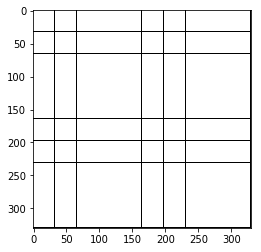

In [126]:
plt.imshow(img)

In [29]:
np.random.randint(0, 10, 123).shape

(123,)

In [32]:
y_train.squeeze().shape

(50000,)

In [5]:
# For WGAN, real = -1, fake = 1

In [8]:
from keras.optimizers import Adam
from lib.model_wgan import *
from lib.utils import *
from param import *

# Set CUDA visible device to GPU:0
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Adam parameters suggested in https://arxiv.org/abs/1511.06434
adam_lr = 0.0002
adam_beta_1 = 0.5
rms_lr = 0.00005

def train(prog=True):
    """Main function to train GAN"""

    # Load MNIST
    x_train, y_train, x_test, y_test = load_mnist()

    # Build model
    d = build_discriminator()
    g = build_generator()

    # Set up optimizers
    #adam = Adam(lr=adam_lr, beta_1=adam_beta_1)
    rms = RMSprop(lr=rms_lr)
    
    # Set loss function and compile models
    g.compile(optimizer=rms, loss='binary_crossentropy')
    d.compile(
        optimizer=rms, 
        loss=[modified_binary_crossentropy, 'sparse_categorical_crossentropy'])
    combined = combine_g_d(g, d)
    combined.compile(
        optimizer=rms,
        loss=[modified_binary_crossentropy, 'sparse_categorical_crossentropy'])

    train_history = defaultdict(list)
    test_history = defaultdict(list)

    n_train = x_train.shape[0]
    n_batch = int(n_train / BATCH_SIZE)
    for epoch in range(N_EPOCH):
        print('Epoch {} of {}'.format(epoch + 1, N_EPOCH))
        progress_bar = Progbar(target=n_batch)

        epoch_g_loss = []
        epoch_d_loss = []

        for index in range(n_batch):
            progress_bar.update(index, force=True)
            d_loss = np.zeros(3)

            # Train the discriminator for N_DIS iterations before training 
            # the generator once
            for _ in range(N_DIS):
                # ----------------- Train discriminator ---------------------- #
                # Train with real samples first
                smp_ind = np.random.choice(n_train, BATCH_SIZE)
                x_real = x_train[smp_ind]
                y_real = y_train[smp_ind]
                y_d = np.array([-1] * BATCH_SIZE)
                d_loss += d.train_on_batch(x_real, [y_d, y_real])
                
                # Train with generated samples, generate samples from g
                z = np.random.normal(0, 1, (BATCH_SIZE, LATENT_SIZE))
                # Sample some labels from p_c
                y_sampled = np.random.randint(0, 10, BATCH_SIZE)
                x_g = g.predict([z, y_sampled.reshape((-1, 1))], verbose=0)
                y_d = np.array([1] * BATCH_SIZE)
                d_loss += d.train_on_batch(x_g, [y_d, y_sampled])
                
            # Log average discriminator loss over N_DIS
            epoch_d_loss.append(d_loss / N_DIS)

            # ---------------- Train generator ------------------------------- #
            # Generate 2 * BATCH_SIZE samples to match d's batch size
            z = np.random.normal(0, 1, (BATCH_SIZE, LATENT_SIZE))
            y_sampled = np.random.randint(0, 10, BATCH_SIZE)
            y_g = np.array([-1] * BATCH_SIZE)

            epoch_g_loss.append(combined.train_on_batch(
                [z, y_sampled.reshape((-1, 1))], [y_g, y_sampled]))

        print('\nTesting for epoch {}:'.format(epoch + 1))
        n_test = x_test.shape[0]

        # ---------------- Test discriminator -------------------------------- #
        z = np.random.normal(0, 1, (n_test, LATENT_SIZE))
        y_sampled = np.random.randint(0, 10, n_test)
        x_g = g.predict([z, y_sampled.reshape((-1, 1))], verbose=0)

        x_d = np.concatenate((x_test, x_g))
        y_d = np.array([-1] * n_test + [1] * n_test)
        y_aux = np.concatenate((y_test, y_sampled), axis=0)

        d_test_loss = d.evaluate(x_d, [y_d, y_aux], verbose=0)
        d_train_loss = np.mean(np.array(epoch_d_loss), axis=0)

        # ---------------- Test generator ------------------------------------ #
        z = np.random.normal(0, 1, (2 * n_test, LATENT_SIZE))
        y_sampled = np.random.randint(0, 10, 2 * n_test)
        y_g = np.array([-1] * 2 * n_test)

        g_test_loss = combined.evaluate(
            [z, y_sampled.reshape((-1, 1))], [y_g, y_sampled], verbose=0)
        g_train_loss = np.mean(np.array(epoch_g_loss), axis=0)

        # generate an epoch report on performance
        train_history['generator'].append(g_train_loss)
        train_history['discriminator'].append(d_train_loss)
        test_history['generator'].append(g_test_loss)
        test_history['discriminator'].append(d_test_loss)

        print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format(
            'component', *d.metrics_names))
        print('-' * 65)

        ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.2f} | {3:<5.2f}'
        print(ROW_FMT.format('generator (train)',
                             *train_history['generator'][-1]))
        print(ROW_FMT.format('generator (test)',
                             *test_history['generator'][-1]))
        print(ROW_FMT.format('discriminator (train)',
                             *train_history['discriminator'][-1]))
        print(ROW_FMT.format('discriminator (test)',
                             *test_history['discriminator'][-1]))

        # Aave weights every epoch
        g.save_weights("{}weight_g_epoch_{:03d}.hdf5".format(
            WEIGHT_DIR, epoch), True)
        d.save_weights("{}weight_d_epoch_{:03d}.hdf5".format(
            WEIGHT_DIR, epoch), True)

        # generate some digits to display
        noise = np.random.uniform(-1, 1, (100, LATENT_SIZE))

        sampled_labels = np.array([
            [i] * 10 for i in range(10)
        ]).reshape(-1, 1)

        # get a batch to display
        generated_images = g.predict(
            [noise, sampled_labels], verbose=0)

        # arrange them into a grid
        img = (np.concatenate([r.reshape(-1, 28)
                               for r in np.split(generated_images, 10)
                               ], axis=-1) * SCALE + SCALE).astype(np.uint8)

        Image.fromarray(img).save(
            '{}plot_epoch_{:03d}_generated.png'.format(VIS_DIR, epoch))

    pickle.dump({'train': train_history, 'test': test_history},
                open('wgan-history.pkl', 'wb'))

In [9]:
train(True)

Epoch 1 of 50
  0/468 [..............................] - ETA: 0s

/home/chawins/.conda/envs/tsa3/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


467/468 [============================>.] - ETA: 0s
Testing for epoch 1:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 2.29 | 0.02            | 2.27 
generator (test)       | 2.20 | 0.04            | 2.16 
discriminator (train)  | 4.57 | 0.00            | 4.56 
discriminator (test)   | 2.20 | -0.02           | 2.22 
Epoch 2 of 50
467/468 [============================>.] - ETA: 0s
Testing for epoch 2:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 2.19 | 0.12            | 2.08 
generator (test)       | 2.18 | 0.14            | 2.04 
discriminator (train)  | 4.32 | -0.03           | 4.35 
discriminator (test)   | 2.10 | -0.05           | 2.15 
Epoch 3 of 50
467/468 [============================>.] - ETA: 0s
Testing for epoch 3:
component              | loss | generation_los

467/468 [============================>.] - ETA: 0s
Testing for epoch 20:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 2.07 | 0.26            | 1.80 
generator (test)       | 2.06 | 0.25            | 1.80 
discriminator (train)  | 3.94 | -0.13           | 4.07 
discriminator (test)   | 1.92 | -0.11           | 2.02 
Epoch 21 of 50
467/468 [============================>.] - ETA: 0s
Testing for epoch 21:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 2.07 | 0.26            | 1.80 
generator (test)       | 2.07 | 0.27            | 1.80 
discriminator (train)  | 3.94 | -0.13           | 4.07 
discriminator (test)   | 1.91 | -0.11           | 2.03 
Epoch 22 of 50
467/468 [============================>.] - ETA: 0s
Testing for epoch 22:
component              | loss | generatio

467/468 [============================>.] - ETA: 0s
Testing for epoch 39:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 2.07 | 0.27            | 1.80 
generator (test)       | 2.07 | 0.27            | 1.79 
discriminator (train)  | 3.93 | -0.13           | 4.06 
discriminator (test)   | 1.92 | -0.11           | 2.02 
Epoch 40 of 50
467/468 [============================>.] - ETA: 0s
Testing for epoch 40:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 2.07 | 0.27            | 1.80 
generator (test)       | 2.06 | 0.27            | 1.80 
discriminator (train)  | 3.94 | -0.13           | 4.06 
discriminator (test)   | 1.91 | -0.11           | 2.02 
Epoch 41 of 50
467/468 [============================>.] - ETA: 0s
Testing for epoch 41:


KeyboardInterrupt: 

In [32]:
g = build_generator()
#g.compile(optimizer="SGD", loss='sparse_categorical_crossentropy')
#g.load_weights(WEIGHT_DIR + "weight_g_epoch_018.hdf5")
g.load_weights(WEIGHT_DIR + "weight_g_epoch_005.hdf5")

d = build_discriminator()
#d.compile(optimizer="SGD", loss='sparse_categorical_crossentropy')
#d.load_weights(WEIGHT_DIR + "weight_d_epoch_018.hdf5")
d.load_weights(WEIGHT_DIR + "weight_d_epoch_005.hdf5")

In [33]:
g.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 1, 100)       1000        input_43[0][0]                   
__________________________________________________________________________________________________
input_42 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
flatten_19 (Flatten)            (None, 100)          0           embedding_10[0][0]               
__________________________________________________________________________________________________
multiply_1

In [42]:
g.layers[-1].get_weights()

[array([[  3.78280804e-02,   3.90699841e-02,  -2.15779338e-03, ...,
           6.64532045e-03,   1.80605855e-02,   6.52331561e-02],
        [ -2.91381460e-02,   3.40126082e-02,  -1.42912909e-01, ...,
          -6.17513582e-02,  -2.44552479e-03,  -8.97833779e-02],
        [  1.12108253e-02,   1.29567206e-01,   1.33207515e-02, ...,
           8.82425606e-02,   7.41734579e-02,  -6.54385658e-05],
        ..., 
        [ -9.30008199e-03,  -6.14549667e-02,  -4.43667620e-02, ...,
          -1.01190314e-01,   5.40581606e-02,   4.08558585e-02],
        [ -2.87669040e-02,  -1.05905803e-02,   5.11248177e-03, ...,
          -6.53349375e-03,  -1.54103595e-03,  -8.06531161e-02],
        [  2.43268255e-03,  -4.13992368e-02,   1.57080172e-03, ...,
          -3.69323231e-03,   2.90765669e-02,  -3.78117785e-02]], dtype=float32),
 array([ 0.00820533, -0.052864  ,  0.00759658, ...,  0.00253871,
        -0.01407321,  0.00079039], dtype=float32),
 array([[ 0.05901076,  0.06434827,  0.07743584, ...,  0.06454

In [41]:
g.get_weights

<bound method Container.get_weights of <keras.engine.training.Model object at 0x7fb0f8785a58>>

In [23]:
d.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 14, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 14, 14, 32)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 14, 14, 32)   0           leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
conv2d_5 (

In [44]:
d.layers[1].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_77 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_78 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 7, 7, 128)         73856     
__________

In [66]:
w = d.layers[1].layers[6].get_weights()
print(w)

[array([[[[-0.00466526, -0.00478109,  0.00469549, ..., -0.00466347,
           0.00476041,  0.00474772],
         [-0.00479064, -0.00486212,  0.00477491, ..., -0.00460266,
           0.00475856,  0.00481216],
         [ 0.00510463,  0.00503958, -0.00495022, ...,  0.0049541 ,
          -0.00480145, -0.00484076],
         ..., 
         [-0.00477714, -0.00485084,  0.00485832, ..., -0.00487119,
           0.00488568,  0.0047249 ],
         [-0.00456475, -0.0047423 ,  0.00471783, ..., -0.00464083,
           0.0045321 ,  0.00459823],
         [-0.00482344, -0.00469361,  0.00482364, ..., -0.00467242,
           0.00495965,  0.00493532]],

        [[-0.0048248 , -0.0049022 ,  0.00489049, ..., -0.00503888,
           0.00488533,  0.00495924],
         [-0.00493808, -0.00501448,  0.00489126, ..., -0.0047537 ,
           0.00479108,  0.00483907],
         [ 0.0045967 ,  0.00498764, -0.00463155, ...,  0.00486901,
          -0.00486386, -0.00489598],
         ..., 
         [-0.00472495, -0.00477

In [62]:
w[0].shape

(3, 3, 1, 32)

In [56]:
d.layers[1].layers

In [ ]:
# separate real, fake batches